# Regularized Logistic Regression 
在这个实验中，是以Logistic回归作为基础，将再次复习Logistic回归，对Logistic回归将有更深的理解。通过对比未进行正则化的Logistic回归与正则化的Logistic回归在相同数据集上的表现来理解正则化缓解过拟合现象的作用。
注：本次实验不再给出理论结果，在你们的训练结果中需要看出加入正则项以后的结果变化。
## 1. 导入Python库
首先，我们导入这次实验所需要使用的Python库，以及辅助函数

In [211]:
import numpy as np
import matplotlib.pyplot as plt

from utils import *

# 2. 知识回顾--过拟合问题分析

实际应用中容易出现过拟合，其原因则在于模型已经足够复杂，但是我们往往根本就不知道设计的模型的复杂程度是否刚好满足要求。

这就需要我们去判断模型是否刚刚好，如何判断是否出现了过拟合或欠拟合呢？我们一般通过将数据分为3个部分，训练集(train set)，验证集(validation set)和测试集(test set)。所谓过拟合就是指模型的泛化能力不强，那么，我们就在验证集上测试模型的泛化能力。如下图所示，我们可以看到，过拟合的时候在验证集上表现不好(即泛化能力不强)。而对于欠拟合，往往在训练集上的表现就可以看出表现不好。
![goodfit_overfit](images/goodfit_overfit.jpg)

如何解决欠拟合和过拟合问题？  
欠拟合(Large Bias)： 增加模型的复杂度
- 收集新的特征
- 增加多项式组合特征   

过拟合(Large Variance)
- 增加数据(very effective, but not always practical)
- 降低模型复杂度：
    - 减少特征
    - #### 正则化(Regularization)：非常有效的方法，可大幅度降低方差（增加偏差）


# 3. 可视化数据

为了方便可视化，我们选用二维的数据方便观察。接下来，我们导入这次实验需要用到的数据，并且对其进行可视化。
设$X$为我们的特征矩阵，$x^{(i)}$为训练集里面的第$i$个样本，$x_j$为样本中的第$j$个特征，则：  
$$X=\begin{bmatrix}x_1^{(1)} & x_2^{(1)} \\ x_1^{(2)} & x_2^{(2)} \\ \vdots & \vdots \\ x_1^{(m)} & x_2^{(m)} \end{bmatrix}$$  
$Y$为一个列向量，$y^{(i)}$代表第$i$个样本对应的标签，则：  
$$Y=\begin{bmatrix}y^{(1)} \\ y^{(2)} \\ \vdots \\ y^{(m)} \end{bmatrix}$$  

这里我们已经将数据分成训练集(对应train.txt)和验证集(对应val.txt)。下面直观地观察一下训练集的数据分布。

The shape of X_train is: (153, 2)
The shape of Y_train is: (153,)


<module 'matplotlib.pyplot' from 'c:\\Users\\86158\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

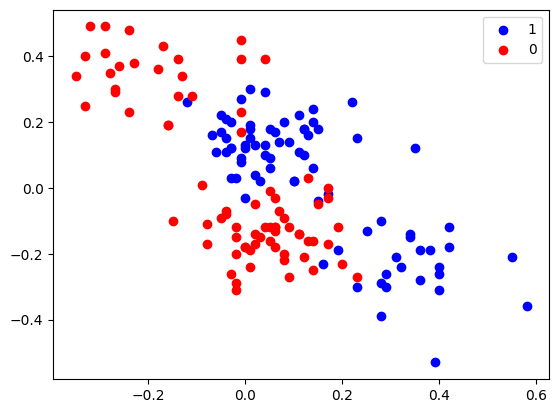

In [212]:
train_data = np.loadtxt('train.txt')
val_data = np.loadtxt('val.txt')
X_train = train_data[:, 0:2].reshape(-1,2)
#reshape,第一个-3表示维度自动计算，2表示每个数组两个数
Y_train = train_data[:, 2]#.reshape(-1,1)
X_val = val_data[:, 0:2].reshape(-1,2)
Y_val = val_data[:, 2]#.reshape(-1,1)

print("The shape of X_train is:", X_train.shape)
print("The shape of Y_train is:", Y_train.shape)

plotData(X_train, Y_train)

# 4. Logistic与Regularized Logistic
现在的任务是使用Logistic对上面的数据集进行分类。根据2中分析，我们可以知道特征较少往往就不能很好拟合数据，而这里只有两个特征，所以这里我们先使用多项式来组合特征。

## 4.1 特征映射

上面的数据只有两个特征，$x_1$和$x_2$，我们按照作业1里多项式回归的相同步骤，将$x_1$和$x_2$映射为最高为6次的多项式。即：
$$mapFeature(x_1,x_2)=\begin{bmatrix}1 \\ x_1 \\ x_2 \\ x_1^2 \\ x_1x_2 \\ x_2^2 \\ \vdots \\ x_1x_2^5 \\ x_2^6 \end{bmatrix}$$  
这里第一维的*1*同作业1线性回归里一样为了方便处理偏置项，将两个特征映射成了$2+3+ \dots +7=27$个特征。算上*1*则多项式回归的参数个数为$28$个。


In [213]:
map_X_train = mapFeature(X_train[:,0], X_train[:,1], degree=6)
print("After mapping the features, the shape of map_X_train is:", map_X_train.shape)

print("X_train[3]",X_train[3,:2]) #看第三行
print(np.shape(map_X_train))
print("map_X_train[3]",map_X_train[3,:])#注意，这才是取某一个维度的办法，这不是c语言


After mapping the features, the shape of map_X_train is: (153, 28)
X_train[3] [ 0.13 -0.16]
(153, 28)
map_X_train[3] [ 1.0000000e+00  1.3000000e-01 -1.6000000e-01  1.6900000e-02
 -2.0800000e-02  2.5600000e-02  2.1970000e-03 -2.7040000e-03
  3.3280000e-03 -4.0960000e-03  2.8561000e-04 -3.5152000e-04
  4.3264000e-04 -5.3248000e-04  6.5536000e-04  3.7129300e-05
 -4.5697600e-05  5.6243200e-05 -6.9222400e-05  8.5196800e-05
 -1.0485760e-04  4.8268090e-06 -5.9406880e-06  7.3116160e-06
 -8.9989120e-06  1.1075584e-05 -1.3631488e-05  1.6777216e-05]


## 4.2 sigmoid函数
我们打算使用Logistic回归训练一个模型，来区分我们的正类与负类，因此我们需要一个Sigmoid函数：  
$$sigmoid(z) = \frac{1}{1+e^{-z}}$$
**注意**：我们写的Sigmoid函数是需要能够对矩阵直接进行操作的。  
**Hint**：计算$e^{-z}$可以使用np.exp(-z)来进行计算  
**任务1**：实现sigmoid函数

In [214]:
def sigmoid(z):
    """
    对矩阵z中每个元素计算其Sigmoid函数值
    """
    ### START CODE HERE ###
    
    g = np.exp(-z)
    #返回一个矩阵
    g=1/(1+g)
    return np.clip(g, 1e-9, 1-1e-9)
    ### END CODE HERE ###
    return g

In [215]:
print(sigmoid(map_X_train[1, :]))

[0.73105858 0.53245431 0.50749944 0.5042249  0.500975   0.500225
 0.50054925 0.50012675 0.50002925 0.50000675 0.5000714  0.50001648
 0.5000038  0.50000088 0.5000002  0.50000928 0.50000214 0.50000049
 0.50000011 0.50000003 0.50000001 0.50000121 0.50000028 0.50000006
 0.50000001 0.5        0.5        0.5       ]


## 4.3 初始化参数
我们简单地权重$\theta$初始化为零向量。  
$$\theta = \begin{bmatrix}\theta_1 \\ \theta_2 \\ \vdots \\ \theta_n \end{bmatrix} $$  
其中$n$为特征的数量。  
**Hint**：使用np.zeros()  
**任务2**：初始化权重$\theta$为零向量。 


In [216]:
def init_parameter(n):
    """
    初始化参数
    :param n : map_X_train的列数
    :return :权重向量
    """
    ### START CODE HERE ###
    
    initial_theta = np.zeros(n)

    ### END CODE HERE ###
    return initial_theta

In [217]:
print("The initialized theta's shape is:",init_parameter(map_X_train.shape[1]).shape)

The initialized theta's shape is: (28,)


## 4.4 预测与计算loss

没有正则项的loss:
$$J(\theta) = -\frac{1}{m} \sum_{i=1}^{m}{[y^{(i)}log(h_{\theta}(x^{(i)}))+(1-y^{(i)})log(1-h_{\theta}(x^{(i)}))]}$$ 
其中，$$h_\theta(X)=g(X\theta)\\ g(z) = sigmoid(z)$$
加入正则项的loss:
$$J(\theta) = -\frac{1}{m} \sum_{i=1}^{m}{[y^{(i)}log(h_{\theta}(x^{(i)}))+(1-y^{(i)})log(1-h_{\theta}(x^{(i)}))]}+\frac{\lambda}{2m}\sum_{j=1}^{n}{\theta_{j}^2}$$  
其中，$\frac{\lambda}{2m}\sum_{j=1}^{n}{\theta_{j}^2}$是正则化项。  
我们从上式中看到，将$\lambda$设置为$0$就可以将有正则项的loss转化为无正则项的loss。因此我们可以来设置$\lambda$观察有正则和无正则的效果。  

预测的时候对于有无正则项都是一样的。
$$
h_{\theta}(x^{(i)}) \ge 0.5 \Rightarrow 为1类 \\
h_{\theta}(x^{(i)}) \lt 0.5 \Rightarrow 为0类 \\
$$

**Hint**:  
`a = np.array([1,2,3,4])`  
`a`的平均值为`a.mean()`或者用`a.sum()`除以`a`的个数。  
`a = np.array([0.3,0.5,0.8])` `a.round()`$\rightarrow$ `[0., 0., 1.]`  
其他一些函数可能会有用:`np.dot()`,`np.log()`,`np.power()`  
**任务3**：完成计算loss的函数   
注意：1.不要`for`循环求和。2.正则项loss不计算第一个权重

In [218]:
def loss(X, y, theta, lambd):
    """
    计算loss
    :param X:特征矩阵X
    :param y:特征矩阵X对应的标签
    :param theta:权重矩阵theta
    :param lambd:正则化参数lambda
    :return: loss
    """
        
    
    ### START CODE HERE ###
    theta=np.reshape(theta,(-1,1))
    y=np.reshape(y,(-1,1))#变成n行一列的
    m = y.shape[1]       #数据的数量
    one=np.ones((m,1))
    #print("theta",theta)
    h = sigmoid(np.dot(X,theta))       #h函数
    #print("h",np.shape(h))
    z = np.sum(np.square(theta[1:,0]))*lambd/(2*m) 
    u1=np.mat(np.log2(h)) 
    u2=np.mat(np.log2(one-h))   #正则化项
    
    J = (np.dot(y.T,u1)+np.dot((one-y).T,u2))*(-1/m)+z
    
    ### END CODE HERE ###
    
    return J[0,0]

In [219]:
test_X = np.array([0.1,0.2,0.3,0.4]).reshape(2,2)
test_y = np.array([0,1])
test_theta = np.array([0.5,0.6])
test_lambd = 1
print('test loss:',loss(test_X, test_y, test_theta, test_lambd))

test loss: 2.0537661668288734


**任务4**：预测分类的函数  
**Hint**: 可能有用的函数：round()

In [220]:
def predict(X, theta):
#重大问题，关键不是array还是matrix，还是数据维度不要转成n*1，就和后面不匹配了


    """
    对数据矩阵预测类别
    :param X:特征矩阵X
    :param theta:权重矩阵theta
    ：return 由 0.,1.组成的向量，维度应该与X.shape[0]一致
    """
    ### START CODE HERE ###
    #theta=np.reshape(theta,(-1,1))#变成n行一列的
    #X=np.array(X)
    #theta=np.array(theta)
    #print(np.shape(theta))
    h = sigmoid(np.dot(X,theta))

    classes = np.round(h)
    
    ### END CODE HERE ###
    #注意结果是1*n
    return classes

In [221]:
test_X = np.array([-0.1,-0.2,-0.3,0.4]).reshape(2,2)
test_theta = np.array([0.5,0.6])
print('test predict:',predict(test_X, test_theta))

test predict: [0. 1.]


## 4.5 计算梯度
梯度计算公式如下(可以自己推导一下)：
$$\frac{\partial J(\theta)}{\partial \theta_0}= \frac{1}{m}\sum_{i=1}^{m}{(h_{\theta}(x^{(i)})-y^{(i)})x_{0}^{(i)}}\qquad j=0$$  
$$\frac{\partial J(\theta)}{\partial \theta_j}=  \big[\frac{1}{m}\sum_{i=1}^{m}{(h_{\theta}(x^{(i)})-y^{(i)})x_{j}^{(i)}}\big]+\frac{\lambda}{m}\theta_{j} \quad j\in\left\{ 1,2,...n \right\}$$ 
为了方便，我们可以先对所有$\theta$(包括$\theta_0$)用下面的式子求梯度，然后再给$\theta_0$的梯度减去$\frac{\lambda}{m}\theta_0$  
**任务5**：完成计算梯度的函数  
**Hint**: 1. 矩阵`A`的转置为`A.T` 2. $\theta$的维度与$\frac{\partial J(\theta)}{\partial \theta}$的维度是一样的 3.矩阵的长宽，或者说向量中的元素个数，可以通过 $X.shape[0]$ 和 $X.shape[1]$ 获得

In [222]:
def compute_grad(X, y, theta, lambd):
    """
    计算梯度
    :param X:特征矩阵X
    :param y:特征矩阵X对应的标签
    :param theta:权重矩阵theta
    :param lambd:正则化参数lambda
    :return : 对theta的梯度，维度应该与theta一致
    """
    #question 上标是什么？i就是行，j就是列，所以i表示第几个数据

#上面的公式是n行1列，与n行m列；结果想要1行m列，所以让前面的去转置
    ### START CODE HERE ###

    theta1=np.reshape(theta,(-1,1))#变成n行一列的
    y=np.reshape(y,(-1,1))#变成n行一列的
    m = y.shape[0]
    h = sigmoid(np.dot(X,theta1))
    

    grad=np.dot((h-y).T,X)/m+lambd*theta/m
    #x1=np.mat((np.dot((h-y).T,X)/m)[0])
    #print(x1)
    #print("1",np.shape(x1))
    #rint("2",np.dot((h-y).T,X)/m)
    #m行1列，xj 
    #x2=np.mat((lambd/m)*theta)
    #print(x2)

    #grad = x1+x2
    
    #print("grad",grad)
    #print(grad[0,0])
    #print(theta[0])
    grad[0,0] = grad[0,0]-lambd/m*theta[0]
    #print(list(grad[0]))
    #print(grad[0,1])
    
    return grad#得到的结果是一个1*n的数组

In [223]:
test_X = np.array([0.1,0.2,0.3,0.4]).reshape(2,2)
test_y = np.array([0,1])
test_theta = np.array([0.5,0.6])
test_lambd = 1
print('test compute_grad:',compute_grad(test_X, test_y, test_theta, test_lambd))

test compute_grad: [[-0.0334377   0.27349633]]


## 4.6 更新参数
更新参数还是使用梯度下降法。公式如下：
$$
 \theta := \theta - \alpha \frac{\partial J(\theta)}{\partial \theta}
$$

**任务6**：完成更新参数的函数 

In [224]:
def update_pameter(theta, gradients, learning_rate):
    """
    更新参数theta
    :param theta:权重theta
    :param gradients:梯度值
    :param learning_rate:学习速率
    :return:更新后的theta
    """
    ### START CODE HERE ###
    #print("thetashape",np.shape(theta))
    #print("gradients",np.shape(theta))
    #theta = np.reshape(theta,(-1,1))
    theta=theta-learning_rate*gradients
    
    ### END CODE HERE ###
    return theta[0,:]

In [225]:
test_X = np.array([0.1,0.2,0.3,0.4]).reshape(2,2)
test_y = np.array([0,1])
test_theta = np.array([0.5,0.6])
test_lambd = 1
test_grad = compute_grad(test_X, test_y, test_theta, test_lambd)
print('test update_pameter:',update_pameter(test_theta, test_grad, 1))

test update_pameter: [0.5334377  0.32650367]


## 4.7 搭积木
接下来，我们将上面的代码整合到我们的模型Model中，并且我们将记录下成本$J$的变化过程。  
**任务7**：完成训练模型函数。

In [226]:
def Model(X, y, theta, iteration=300000, learning_rate = 1, lambd = 0):
    
    """
    Regulared Logistic Regression Model
    :param X:输入X
    :param y:标签Y
    :param theta:参数theta
    :param iteration:迭代次数
    :param learning_rate:学习率
    :param lambd:正则化参数lambda
    :return:最终theta的值、theta的历史记录、loss的历史记录和精确度的历史记录
    """
    theta_history = []
    J_history = []
    acc_history = []
    for i in range(iteration):
        
        ### START CODE HERE ###
        
        gradients = compute_grad(X,y,theta,lambd)
        theta = update_pameter(theta,gradients,learning_rate)
        
        ### END CODE HERE ###
        
        if i%10000==0:
            J = loss(X, y, theta, lambd)
            J_history.append(J)
            pred = predict(X, theta)
            acc_history.append((pred==y).mean())
            theta_history.append(theta)
    
    return theta,theta_history, J_history, acc_history

# 5.训练模型与分析

## 5.1 无正则项
无正则项只需设置$\lambda=0$即可，下面是无正则项时在训练集和验证集上的表现以及在训练集上的分类边界。

In [227]:
# 1. 特征映射
map_X_train = mapFeature(X_train[:,0], X_train[:,1], degree=6)
map_X_val = mapFeature(X_val[:,0], X_val[:,1], degree=6)
#print(np.shape(map_X_train))
# 2. 初始化参数
theta = init_parameter(map_X_train.shape[1])
#28行，1列
#print(np.shape(theta))
# 3. 训练
theta,theta_history, J_history, acc_history = Model(map_X_train, Y_train, theta, iteration=300000, learning_rate = 1, lambd = 0)
# 4. 验证集上验证
acc_val_history = []
J_val_history = []
for i in range(len(theta_history)):
    acc_val = (predict(map_X_val, theta_history[i])==Y_val).mean()
    acc_val_history.append(acc_val)
    J_val = loss(map_X_val, Y_val, theta_history[i], 0)
    J_val_history.append(J_val)
# 5. 分析

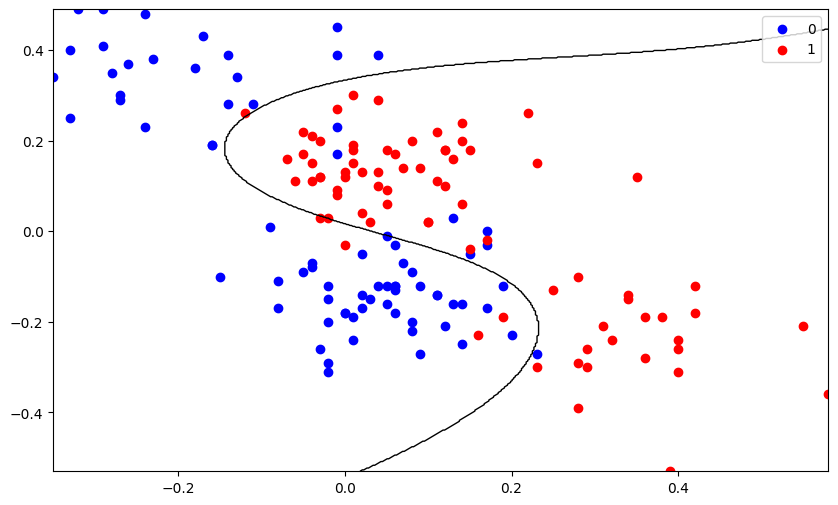

<module 'matplotlib.pyplot' from 'c:\\Users\\86158\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [228]:
# 5.1 绘制分类边界
plotDecisionBoundary(X_train, Y_train,theta)

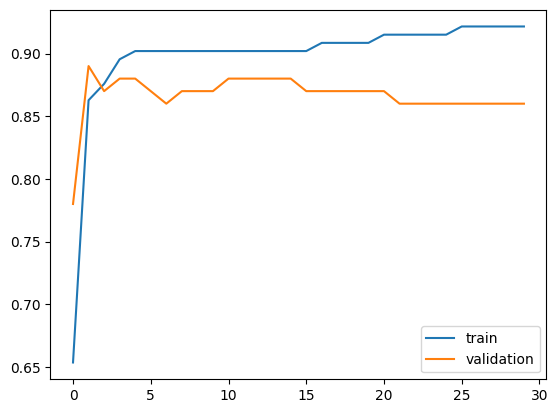

In [229]:
# 5.2 比较预测精确度
plt.plot(acc_history,label='train')
plt.plot(acc_val_history,label='validation')
plt.legend()

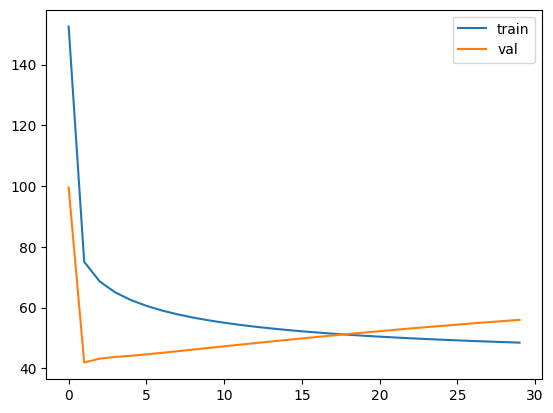

In [230]:
# 5.3 比较loss
plt.plot(J_history,label='train')
plt.plot(J_val_history,label='val')
plt.legend()

从训练过程中的分类精确度分析可知，随着训练次数增加，在训练集上的精确度会进一步提升，但是在验证集上的精确度有轻微的下降。  
从训练过程中的loss分析可知，随着训练次数增加，在训练集上的loss会进一步降低，但是在验证集上的loss会有些发散。  
这些都说明了训练的模型已经过拟合，需要降低模型复杂度来提高泛化能力。

## 5.2 有正则项
这里设置$\lambda=0.005$，可以再提交作业后尝试设置不同的值观察结果。

In [231]:
# 1. 特征映射
map_X_train = mapFeature(X_train[:,0], X_train[:,1], degree=6)
map_X_val = mapFeature(X_val[:,0], X_val[:,1], degree=6)
# 2. 初始化参数
theta = init_parameter(map_X_train.shape[1])
# 3. 训练
theta,theta_history, J_history, acc_history = Model(map_X_train, Y_train, theta, iteration=300000, learning_rate = 1, lambd = 0.005)
# 4. 验证集上验证
acc_val_history = []
J_val_history = []
for i in range(len(theta_history)):
    acc_val = (predict(map_X_val, theta_history[i])==Y_val).mean()
    acc_val_history.append(acc_val)
    J_val = loss(map_X_val, Y_val, theta_history[i], 0)
    J_val_history.append(J_val)
# 5. 分析

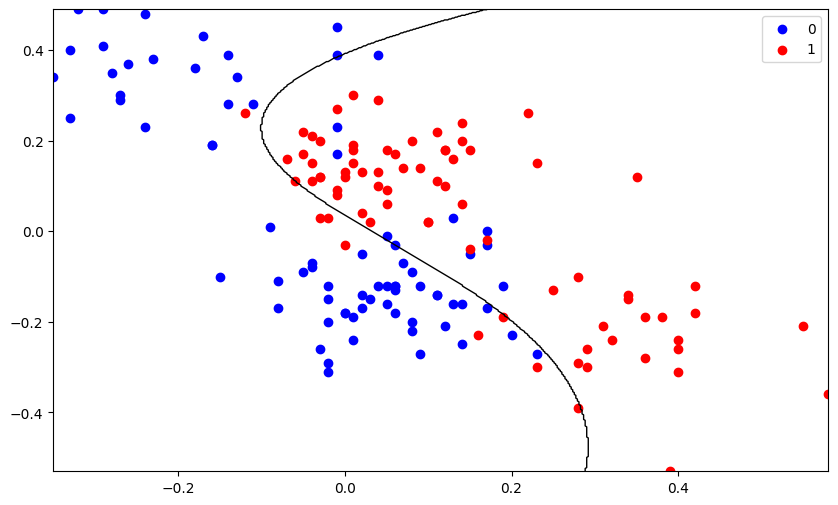

<module 'matplotlib.pyplot' from 'c:\\Users\\86158\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [232]:
# 5.1 绘制分类边界
plotDecisionBoundary(X_train, Y_train,theta)

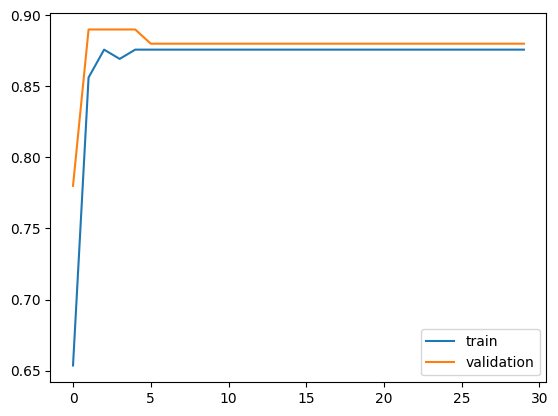

In [233]:
# 5.2 比较预测精确度
plt.plot(acc_history,label='train')
plt.plot(acc_val_history,label='validation')
plt.legend()

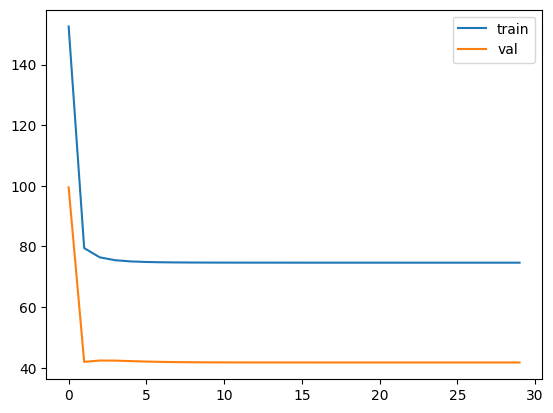

In [234]:
# 5.3 比较loss
plt.plot(J_history,label='train')
plt.plot(J_val_history,label='val')
plt.legend()

对比无正则项的实验结果，我们可以发现有正则项的模型明显提升了泛化能力，过拟合的现象大大减小。


# 6 总结
通过这次实验，我们能够直观的理解正则化对于缓解过拟合现象所起到的作用。在提交完作业后，你还可以试试不同的$\lambda$值，观察决策边界的变化。

In [235]:
#自用：array和matrix区别
import numpy as np

# 创建二维数组（矩阵）
arr = np.array([[1, 2], [3, 4]])
mat = np.matrix([[1, 2], [3, 4]])

print("type(arr):", type(arr))  # 输出：type(arr): <class 'numpy.ndarray'>
print("type(mat):", type(mat))  # 输出：type(mat): <class 'numpy.matrix'>

# 矩阵乘法操作
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])

mat_a = np.matrix([[1, 2], [3, 4]])
mat_b = np.matrix([[5, 6], [7, 8]])

print("a * b =")
print(a * b)
print("np.dot(a, b) =")
print(np.dot(a, b))

print("mat_a * mat_b =")
print(mat_a * mat_b)
print("np.dot(mat_a, mat_b) =")
print(np.dot(mat_a, mat_b))

# 转置操作
print("arr.T:")
print(arr.T)
print("mat.T:")
print(mat.T)

# 求逆矩阵
inv_mat = np.linalg.inv(mat)
print("inv_mat:")
print(inv_mat)


type(arr): <class 'numpy.ndarray'>
type(mat): <class 'numpy.matrix'>
a * b =
[[ 5 12]
 [21 32]]
np.dot(a, b) =
[[19 22]
 [43 50]]
mat_a * mat_b =
[[19 22]
 [43 50]]
np.dot(mat_a, mat_b) =
[[19 22]
 [43 50]]
arr.T:
[[1 3]
 [2 4]]
mat.T:
[[1 3]
 [2 4]]
inv_mat:
[[-2.   1. ]
 [ 1.5 -0.5]]
